# Time Series Analysis II PII

### 05/17/2022

| $\text{Type}$     | $\text{Maturity}$                        |
| ----------------- | ---------------------------------------- |
| $\text{Bill (b)}$ | $1\text{m} \leq \text{T} \lt 1\text{Y}$  |
| $\text{Note (N)}$ | $1\text{Y} \leq \text{T} \lt 10\text{Y}$ |
| $\text{Bond (B)}$ | $\quad\quad\ \text{T} \geq 10\text{Y}$   |

## What is a Constant Maturity Treasury?

According to [Investopedia](https://www.investopedia.com/terms/c/constantmaturity.asp), Constant Maturity is an adjustment for equivalent maturity, used by the Federal Reserve Board to compute an index based on the average yield of various Treasury securities, maturing at different periods. One would use constant maturity yields as reference for pricing various kinds of depts or fixed income securities. Fixed income securities are by far the largest type of security in U.S. securities markets.

## Nominal Yield Curve Rates vs. Real Yield Curve Rates

According to the Board of Governors of the Federal Reserve System, a [nominal Treasury security](https://www.federalreserve.gov/data/nominal-yield-curve.htm) is an issuance that specifies principal and interest as fixed dollar amounts to the holder. Since Treasury securities are backed by the full faith and credit of the U.S. government, the returns investors can earn on them are often used as a “risk-free” benchmark in finance research and investment practice. These securities are a promise to repay the principal (with interest if a note or a bond) to the holder (can be a public or private entity). Therefore, the real yield curve rate would be adjusted for inflation of interest rates, thereby used to determine risk-neutral cashflow.

The **nominal yield curve rate** adds a market average of the expected inflation risk premium to the real. Investors must be compensated for the risk of inflation in bond yields. The real yield determines the cashflow an investor in secondary markets can obtain by purchasing $\text{TIPS}$, which are Inflation Protected Securities offered by the U.S. Treasury department and other stakeholders that offer similar inflation protection to investors.

## Par [Nominal] Yield Curve Rates vs. Par Real Yield Curve Rates

The **par yield** of a coupon security is the coupon rate for which the nominal value of a bond is equivalent to its market price (technically the bond price is zero, considering that the bond would have matured by this point, thereby making it worthless). On the par yield curve, the coupon rate equals the yield to maturity (YTM) of the security (ref: [Investopedia](https://www.investopedia.com/terms/p/par-yield-curve.asp) has more information). The difference between *nominal* and *real* is as described above.

## Statement of Purpose

The purpose of this time series analysis is to work on the "next steps" highlighted under `Treas TS Analysis`. These steps are as follows:

1. Time-Series Forecasting
2. Cross-Validation and Testing on New Data
3. Vector Autoregressive Fractional Integrated Moving Average
4. Markov Chain Monte Carlo
5. Heteroscedastic Models
6. Fourier Analysis and Spectral Analysis

The first step subsequent to the analysis in `Treas TS Analysis` is to do forecasting. I would need to define a "forecast origin", how many steps I can take beyond the forecast origin and what is the prediction error. Hopefully, I have better forecasts than what I obtained in `Treas Exploratory Analysis` using a "top down" approach.

The second step is done to avoid "over-fitting" (more autoregressive parameters than observations) or "under-fitting" (less autoregressive parameters than observations). For time series, regressors, also known as "explanatory variables", are the lagged W values I found earlier, under `Treas TS Analysis`. There are other variables beyond the scope of the R-CMT and N-CMT rates explored in these notebooks, such as price of any specific security (reminder that these prices are based on an index of the average yield, meaning that they are not based on the price of any particular security present in the market at the time), the average strike placed by investors, the average per capita savings, the per capita debt, the Gross National Product of the USA, &c.

The third step goes beyond ARIMA, exploring VARFIMA models. I will be making subsequent forecasts with these VARFIMA models, making cross-validations where adequate, and including an overall view of all maturities under study in a multivariate time series.

The fourth step tests both the basic ARIMA models and the VARFIMA models using the MCMC method. This is a durability test for any univariate, bivariate or multivariate distribution. Realistically, it is the posterior distribution what is being tested using the MCMC method, meaning "after the fact", after taking into account all relevant evidence or background on the particular data being examined or analyzed.

The fifth step is on Heteroscedastic Models. Here, I will be taking a deeper inspection into the "residuals" of the model in question, running variance analyses, testing for ARCH-effects, building GARCH-family models (any of GARCH, IGARCH, GARCH-M, E-GARCH, T-GARCH and CHARMA).

The sixth and last step is to run a Fourier Analysis for unimodal, bimodal, trimodal, &c., or multimodal plot of bond rates, yield curve rates, bond maturity, convexity or price. A question researchers may have is "What is the power of a bond rate?" Spectral analysis can be quite handy for testing power on a cross-sectional basis.

## Time Series Forecasting (Continued)

Earlier, in `Treas TS Analysis`, it was determined that a first order of differencing is optimal, according to the results of the Augmented Dickey-Fuller Test. A priori, I can say with `95%` confidence, that a higher order of differencing will not work for any of the $2019$ US Treasury securities analysed in this study. However, I will try with a second order of differencing, just to prove the point. I have that: 

In [1]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math as mt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

def maxlike(fc, i):
    ml = np.array(np.abs(test[i] - fc))**2
    d = {"rmse" : np.sqrt([sum(ml) / len(ml)]), "cv" : np.std(test) / np.mean(test)}
    return d

def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

data = pd.read_csv("tnf.csv");

# create training
train = data[:int(.75*len(data)) ]

# create test
test  = data[ int(.75*len(data)):]

import itertools

ps = range(0, 8, 1)
d = 2
qs = range(0, 8, 1)

# Create a list with all possible combination of parameters
parameters = itertools.product(ps, qs)
parameters_list = list(parameters)

!jupyter nbextension enable --py widgetsnbextension --sys-prefix

from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, 2)
    each = tuple(each)
    order_list.append(each)

key = ['x5', 'x7', 'x10', 'x20', 'x30']
result_df = [optimize_ARIMA(order_list, exog=train[k]) for k in iter(key)]

# rework training for indexing
train = []
for k in iter(key):
    train.append(data[k][:int(0.75*len(data))])

# rework test for indexing
test = []
for k in iter(key):
    test.append( data[k][ int(0.75*len(data)):])

order_lists = []
res = iter(result_df)

for r in res:
    order_lists.append(r["(p, d, q)"])

mods = [[], [], [], [], []]
J = range(0, len(result_df[0]))

for i in range(0, 5):
    order_list = order_lists[i]
    for j in J:
        mods[i].append(ARIMA(endog=train[i], order=order_list[j]))

fits = [[], [], [], [], []]
for i in range(0, 5):
    modc = mods[i]
    for j in J:
        fits[i].append(modc[j].fit())

if len(fits[0]) == len(fits[1]) == len(fits[2]) == len(fits[3]) == len(fits[4]) == 64:
    fc_xx = [[], [], [], [], []]
    for i in range(0, 5):
        fit = fits[i]
        for j in J:
            fc_xx[i].append(fit[j].forecast(int(.25*len(data)+1), alpha=0.05))

    ml = [((0, 0), 100.0), ((0, 0), 100.0), ((0, 0), 100.0), ((0, 0), 100.0), ((0, 0), 100.0)]
    for i in range(0, 5):
        for j in J:
            m = maxlike(fc_xx[i][j], i)
            if m['rmse'][0] < ml[i][1]:
                ml[i] = ((i, j), m['rmse'][0])

for i in range(0, 5):
    print(fits[i][ml[i][0][1]].summary())

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok
100%|██████████████████████████████████████████| 64/64 [02:06<00:00,  1.98s/it]


                               SARIMAX Results                                
Dep. Variable:                     x5   No. Observations:                  187
Model:                 ARIMA(0, 2, 6)   Log Likelihood                 282.337
Date:                Tue, 05 Jul 2022   AIC                           -550.675
Time:                        19:50:27   BIC                           -528.132
Sample:                             0   HQIC                          -541.539
                                - 187                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9888      0.073    -13.541      0.000      -1.132      -0.846
ma.L2          0.0247      0.104      0.238      0.812      -0.179       0.228
ma.L3         -0.0365      0.104     -0.352      0.7

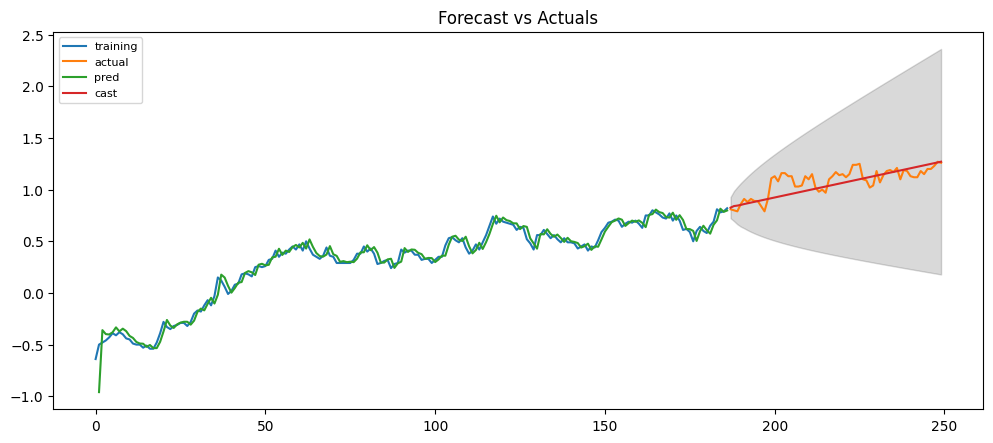

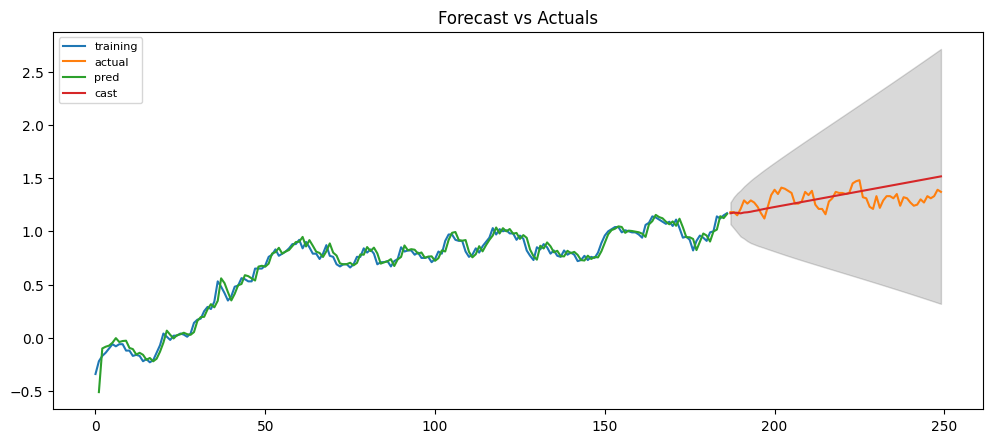

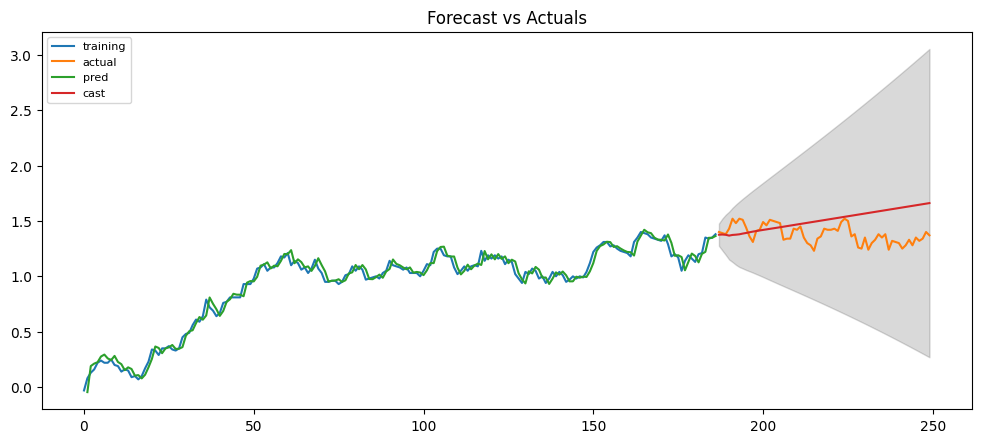

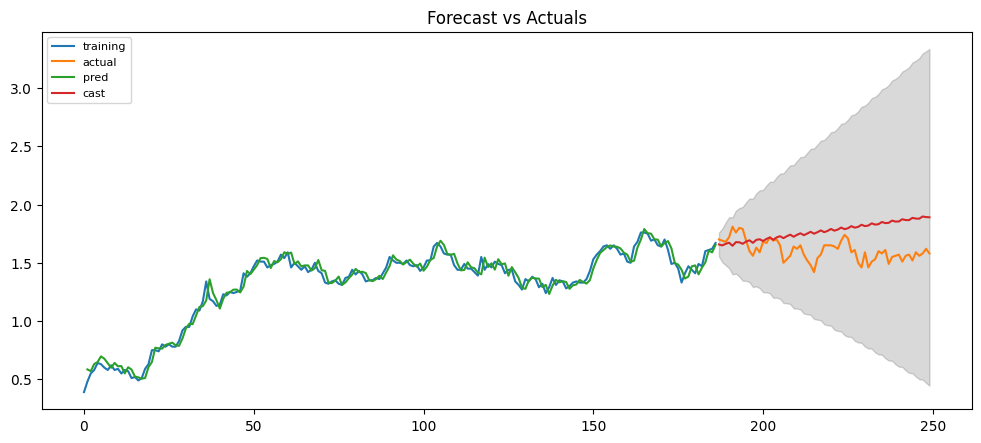

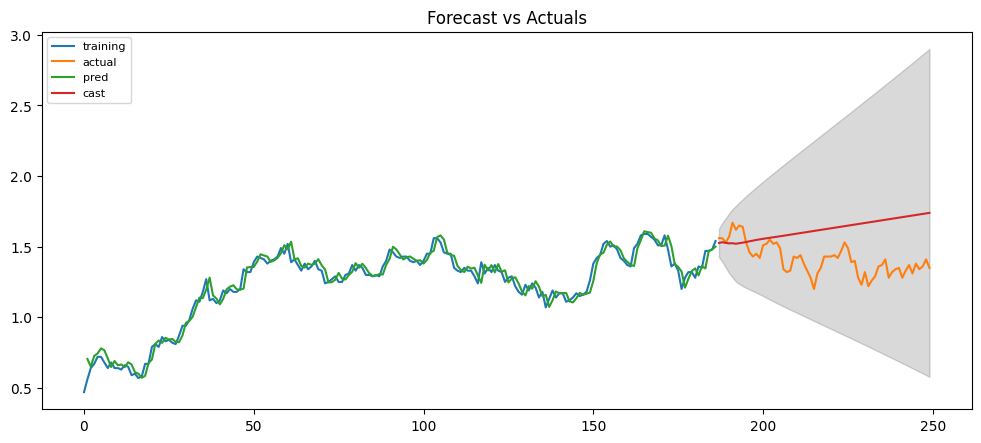

In [2]:
lo = ['lower x5', 'lower x7', 'lower x10', 'lower x20', 'lower x30']
hi = ['upper x5', 'upper x7', 'upper x10', 'upper x20', 'upper x30']

# Forecasts
pd_xx = []
fc_xx = []
fd_xx = []
fit   = []

for i in range(0, 5):
    fit.append(fits[i][ml[i][0][1]])

for f in fit:
    pd_xx.append(f.predict(1, alpha=0.05, dynamic=False))
    fc_xx.append(f.forecast(int(.25*len(data)+1), alpha=0.05))
    fd_xx.append(f.get_forecast(int(.25*len(data)+1), alpha=0.05))

lower_xx_series = []; upper_xx_series = []
for I in range(0, 5):
    lower_xx_series.append(fd_xx[I].conf_int(alpha=0.05)[lo[I]])
    upper_xx_series.append(fd_xx[I].conf_int(alpha=0.05)[hi[I]])

# Plot
for I in range(0, 5):
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train[I], label='training')
    plt.plot(test[I], label='actual')
    plt.plot(pd_xx[I], label = 'pred')
    plt.plot(fc_xx[I], label = 'cast')
    plt.fill_between(lower_xx_series[I].index, lower_xx_series[I], upper_xx_series[I],
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

I have sufficient evidence from above to conclude that the first order of differencing is optimal for $t \in [7, 10, 20, 30]$ and there is no improvement to make on the models determined under `Treas TS Analysis II PI`. There is prediction improvement for $25\%$ of the data under the test set for $t \in 5$. However, I can still filter the time series for more accurate prediction on the noise.

For now, let us gather all the results together onto a single set of models.

In [3]:
import pickle
old_fits = []

with (open("fits", "rb")) as f:
    while True:
        try:
            old_fits.append(pickle.load(f))
        except EOFError:
            break

new_fits = [[], [], [], [], []]
new_fits[0] = fits[0]
for i in range(1, 5):
    new_fits[i] = old_fits[0][i]

In [4]:
import pickle
old_ml = []

with (open("ml", "rb")) as g:
    while True:
        try:
            old_ml.append(pickle.load(g))
        except EOFError:
            break

new_ml = [ml[0]] + old_ml[0][1:5]

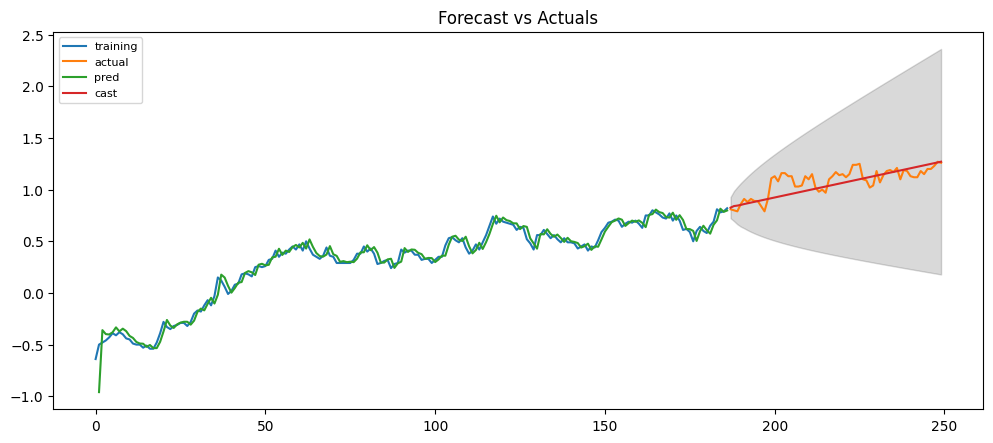

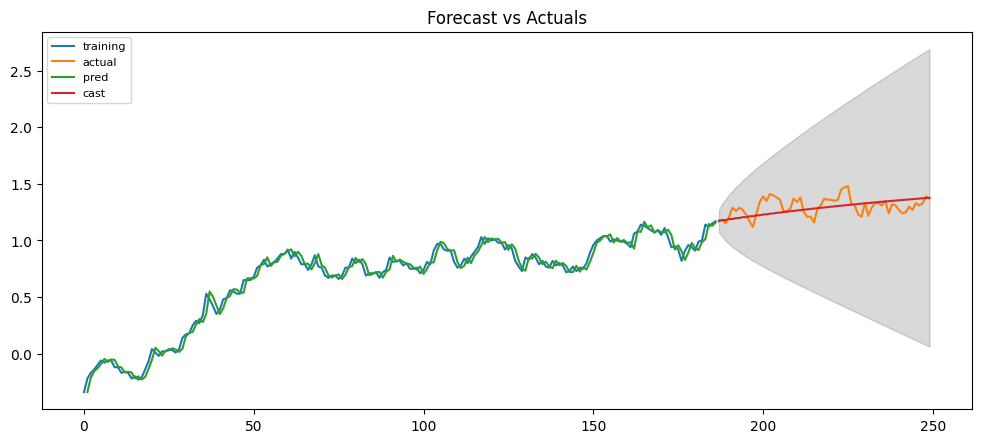

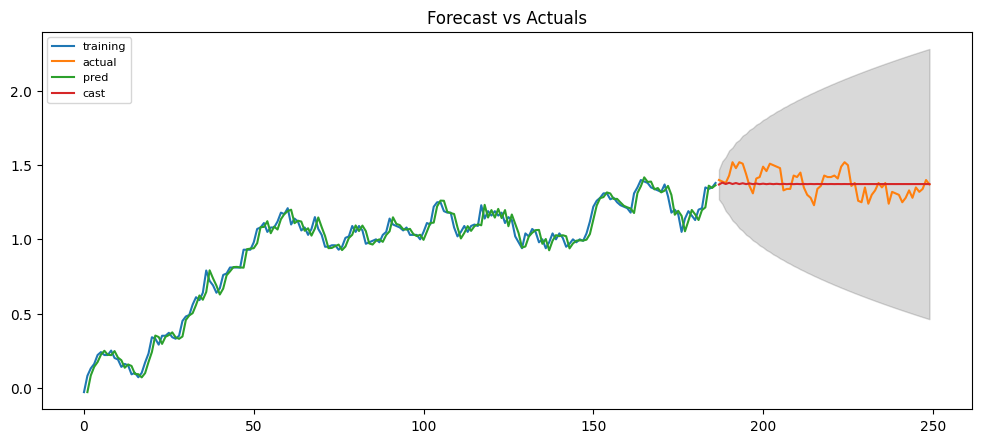

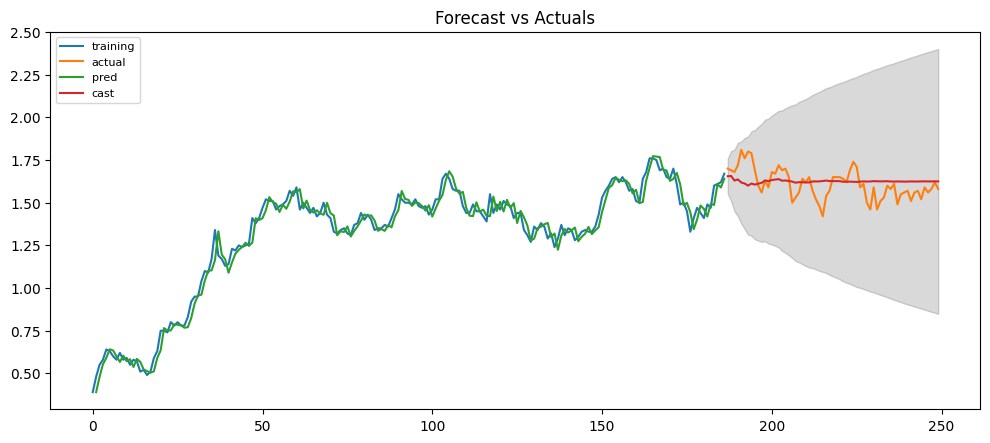

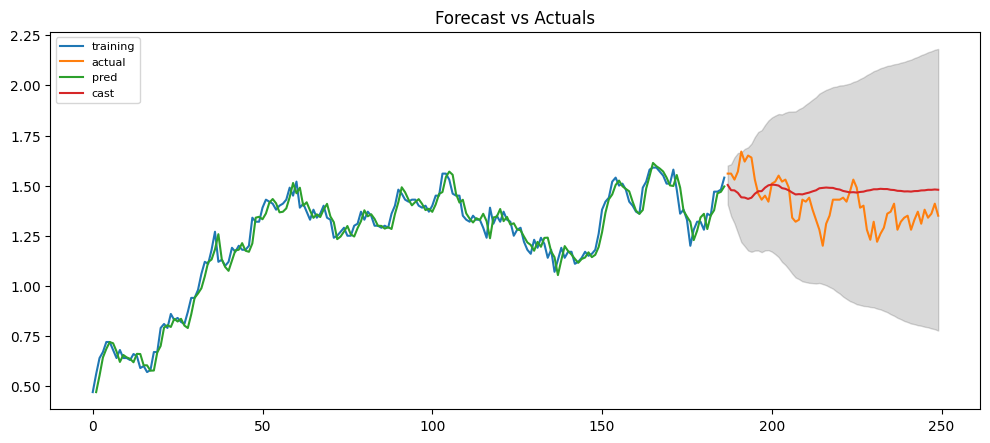

In [5]:
lo = ['lower x5', 'lower x7', 'lower x10', 'lower x20', 'lower x30']
hi = ['upper x5', 'upper x7', 'upper x10', 'upper x20', 'upper x30']

# Forecasts
pd_xx = []
fc_xx = []
fd_xx = []
fit   = []

for i in range(0, 5):
    fit.append(new_fits[i][new_ml[i][0][1]])

for f in fit:
    pd_xx.append(f.predict(1, alpha=0.05, dynamic=False))
    fc_xx.append(f.forecast(int(.25*len(data)+1), alpha=0.05))
    fd_xx.append(f.get_forecast(int(.25*len(data)+1), alpha=0.05))

lower_xx_series = []; upper_xx_series = []
for I in range(0, 5):
    lower_xx_series.append(fd_xx[I].conf_int(alpha=0.05)[lo[I]])
    upper_xx_series.append(fd_xx[I].conf_int(alpha=0.05)[hi[I]])

# Plot
for I in range(0, 5):
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train[I], label='training')
    plt.plot(test[I], label='actual')
    plt.plot(pd_xx[I], label = 'pred')
    plt.plot(fc_xx[I], label = 'cast')
    plt.fill_between(lower_xx_series[I].index, lower_xx_series[I], upper_xx_series[I],
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

Now, I build the Kalman filter.

## Kalman Filtering Time Series Noise

To filter the noisy data, I use the following code, borrowed from pages $11-15$ of "An Introduction to the Kalman Filter" by Greg Welch and Gary Bishop. This produces more accurate predictions.

### For the $20$Y CMT Bond

I define the `kalman` function

In [155]:
def kalman(t, n_iter):
    # Kalman filter example demo in Python

    # A Python implementation of the example given in pages 11-15 of "An
    # Introduction to the Kalman Filter" by Greg Welch and Gary Bishop,
    # University of North Carolina at Chapel Hill, Department of Computer
    # Science, TR 95-041,
    # http://www.cs.unc.edu/~welch/kalman/kalmanIntro.html

    # by Andrew D. Straw

    import numpy
    import pylab

    # intial parameters
    n_iter = n_iter # 50
    sz = (n_iter,) # size of array
    x = -0.37727 # truth value (typo in example at top of p. 13 calls this z)
    z = numpy.array(t) # numpy.random.normal(x,0.1,size=sz) # observations (normal about x, sigma=0.1)

    Q = 1e-5 # process variance

    # allocate space for arrays
    xhat=numpy.zeros(sz)     # a posteri estimate of x
    P=numpy.zeros(sz)         # a posteri error estimate
    xhatminus=numpy.zeros(sz) # a priori estimate of x
    Pminus=numpy.zeros(sz)    # a priori error estimate
    K=numpy.zeros(sz)         # gain or blending factor

    R = 0.0028 # 0.1**2 # estimate of measurement variance, change to see effect

    # intial guesses
    xhat[0] = 1.56
    P[0] = 1.0

    for k in range(1,n_iter-1):
        # time update
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1]+Q

        # measurement update
        K[k] = Pminus[k]/( Pminus[k]+R )
        xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
        P[k] = (1-K[k])*Pminus[k]

    pylab.figure()
    pylab.plot(z,'k+',label='noisy measurements')
    pylab.plot(xhat,'b-',label='a posteri estimate')
    pylab.axhline(x,color='g',label='truth value')
    pylab.legend()
    pylab.xlabel('Iteration')
    pylab.ylabel('Voltage')

    pylab.figure()
    valid_iter = range(1,n_iter) # Pminus not valid at step 0
    pylab.plot(valid_iter,Pminus[valid_iter],label='a priori error estimate')
    pylab.xlabel('Iteration')
    pylab.ylabel('$(Voltage)^2$')
    pylab.setp(pylab.gca(),'ylim',[0,.01])
    pylab.show()
    return xhat

I plot noise predictions (a posteri estimates) with respective variances, saving the a posteri estimates as `x1hat` and `x2hat`.

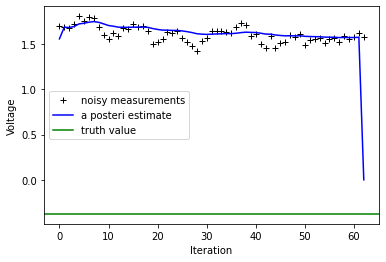

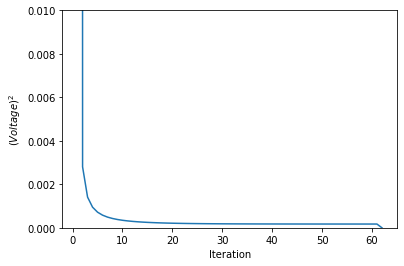

In [157]:
x1hat = kalman(test[3], n_iter = 63)

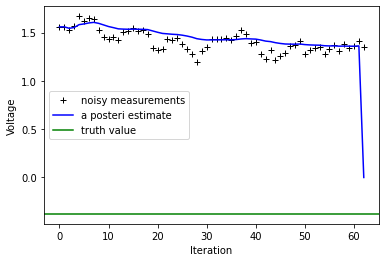

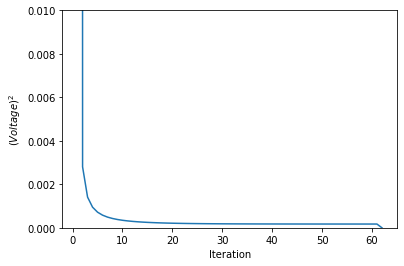

In [158]:
x2hat = kalman(test[4], n_iter = 63)

Then making a shallow copy of the training data for bonds $t \in [20, 30]$Y,

In [160]:
import copy

xhats = [x1hat, x2hat]
for J in range(3, 5):
    tmp = copy.deepcopy(train[J])
    c = 0
    for I in range(187, 250):
        # tmp.index += 1
        tmp.loc[I] = xhats[J-3][c]
        c += 1

    # tmp.sort_index()
    fc_xx[J] = tmp[187:249]

I replot my forecasts.

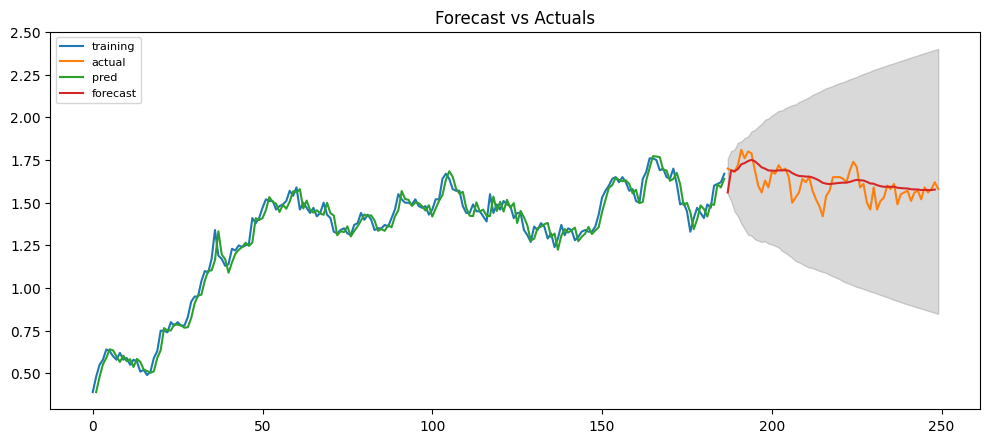

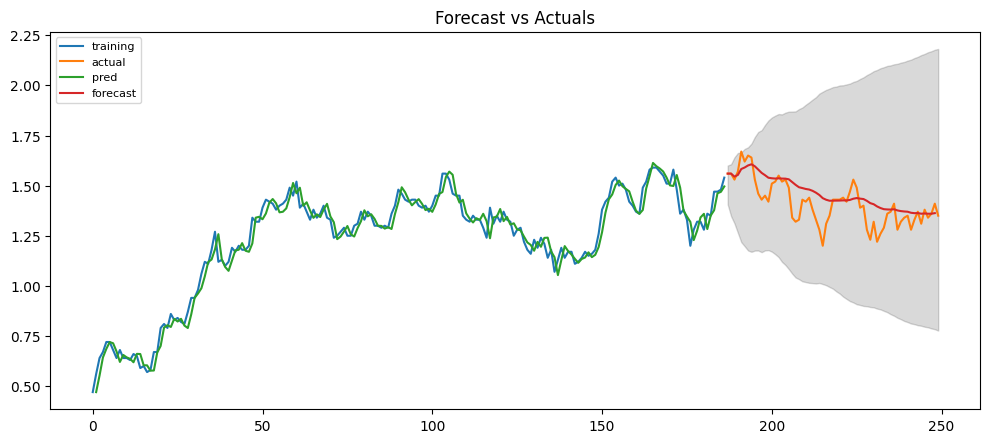

In [161]:
# Plot
for I in range(3, 5):
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train[I], label='training')
    plt.plot(test[I], label='actual')
    plt.plot(pd_xx[I], label = 'pred')
    plt.plot(fc_xx[I], label = 'forecast')
    plt.fill_between(lower_xx_series[I].index, lower_xx_series[I], upper_xx_series[I],
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

## Vector Auto-Regressive Fractional Integrated Moving Average ($\text{VARFIMA}$)

In order to get to a $\text{VARFIMA}$ model, I need to begin with $\text{VARIMA}$. Using the fitted models, in matrix notation,

$
    \text{Let} \\~\\
    \quad\quad \mathcal{V} = \left(\begin{matrix} w_{t - 1} \\ w_{t - 2} \\ w_{t - 3} \\ w_{t - 4} \\ w_{t - 5} \\ w_{t - 6} \\ w_{t - 7} \end{matrix}\right) \quad \text{and} \quad \mathcal{E} = \left(\begin{matrix} \epsilon_{t - 1} \\ \epsilon_{t - 2} \\ \epsilon_{t - 3} \\ \epsilon_{t - 4} \\ \epsilon_{t - 5} \\ \epsilon_{t - 6} \\ \epsilon_{t - 7} \end{matrix}\right), \quad \text{for} \quad \mathcal{M} = \left( \begin{matrix} (0, 2, 6) \\ (5, 1, 2) \\ (5, 1, 2) \\ (5, 1, 6) \\ (7, 1, 7) \end{matrix} \right) \quad \text{with} \quad \mathcal{T} = \left( \begin{matrix} 05 \\ 07 \\ 10 \\ 20 \\ 30 \end{matrix} \right) \\~\\
    \text{Then} \\~\\
$

$$
    \mathcal{F(M)} = \left( \begin{matrix}
        +0.0000 & +0.0000 & +0.0000 & +0.0000 & +0.0000 & +0.0000 & +0.0000 \\
        +0.0342 & +1.0148 & +0.0019 & -0.0846 & +0.0151 & +0.0000 & +0.0000 \\
        -0.2955 & +0.4938 & +0.7694 & +0.0000 & +0.0000 & +0.0000 & +0.0000 \\
        -0.0971 & -0.2287 & +0.1748 & +0.0414 & +0.5051 & -0.0497 & +0.0000 \\
        +0.2214 & +0.9161 & -0.1688 & +0.0000 & +0.0000 & +0.0000 & +0.0000
    \end{matrix} \right)\mathcal{V} \quad\quad + \ \left( \begin{matrix}
        -0.9888 & +0.0247 & +0.0365 & -0.0242 & +0.0934 & -0.0596 & +0.0000 \\
        +0.0281 & -0.9694 & +0.0000 & +0.0000 & +0.0000 & +0.0000 & +0.0000 \\
        +0.3199 & -0.3504 & -0.7855 & -0.1419 & -0.1484 & -0.0042 & +0.1165 \\
        +0.1140 & +0.4883 & -0.2435 & -0.0559 & -0.7662 & +0.0000 & +0.0000 \\
        -0.1069 & -0.8657 & +0.0000 & +0.0000 & +0.0000 & +0.0000 & +0.0000
    \end{matrix}\right) \mathcal{E}
$$

$\mathcal{V}$ is a vector of lagged, differenced values. $\mathcal{E}$ is a vector of error terms. $\mathcal{E}$ is not the variance of the $\text{VARIMA}$ model itself (i.e., $\sigma^2 = (0.0026, 0.0030, 0.0029, 0.0030, 0.0029)^t$).

I recall the $H_0$ hypothesis from `Treas TS Analysis`, that $\hat{Y_t} = \mu + \phi Y_{t - 1}$. There is a way to estimate $\hat{Y_t}$, but what is the constant term $\mu$? Maybe some fourier analysis will help to figure out whether $\hat{Y_t}$ is unimodal, bimodal, or even trimodal. A measure of frequency, the mode, once again becomes important in the estimation of parameters.

## Fourier Analysis

TODO:

* Determine the "modality" of the time series.
* Fourier Transform for Modeling Seasonal Behavior
* Perform a Spectral Analysis and Draw a Heat Map